# Proyecto final

Este notebook contiene el desarrollo del proyecto final de la asignatura Caracterización de Redes y Topologías Biológicas (Máster de Bioinformática y Biología Computacional, UAM).

Autores: **Diego Mañanes Cayero** y **Alejandro Martín Muñoz**

In [1]:
# En primer lugar, se importan las librerías necesarias

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import string
import copy
import os
import pickle
from community import community_louvain

## Introducción

El sistema modelo de *Drosophila melanogaster* (mosca de la fruta) ha sido y es utilizado para entender la biología, desarrollo y enfermedades humanas. Dicho estudio implica la construcción de mapas de interacción entre proteínas, cuyo análisis y visualización requiere de la aplicación de la teoría de grafos. En el caso de este trabajo, se ha centrado en el estudio de un dataset de interacciones proteicas de dicho organismo modelo, descargado del apartado de datasets de ejemplo de la base de datos GraphWeb la cual, a su vez, extrajo los datos a utilizar de la base de datos IntAct.

Con el objetivo de estudiar esta red, se procede a responder a una serie de preguntas sobre el grafo. Para poder responder a muchas de estas preguntas, se requiere el uso de las funciones proporcionadas por el módulo ``networkx`` de forma que, antes de nada, se va a proceder a cargar dicha red:

In [2]:
# Carga del grafo
G_DM = nx.read_edgelist("./datos/Fly_protein_interactions.txt")

* a. ¿Es ponderado?

El grafo de estudio se lee a partir de un fichero en formato txt, el cual consiste en un una lista de ramas. Es decir, cada línea constituye una rama del grafo, en la que la única información disponible son los nodos de origen y destino de la rama en cuestión. Por tanto, este grafo no es ponderado porque, en caso de que lo fuera, debería especificarse el peso asignado a cada rama particular, cuando no es así.

* b. ¿Cuál es su tamaño y su orden? ¿Es un grafo dirigido o no? ¿Es un grafo denso o disperso?

In [3]:
# Cálculos
n = nx.number_of_nodes(G_DM)
m = nx.number_of_edges(G_DM)
info = nx.info(G_DM)
directionality = nx.is_directed(G_DM)
dens = nx.density(G_DM)

# Respuestas
display(Markdown("""
<br>
Respecto al orden y el tamaño del grafo, estas métricas pueden calcularse a través de las funciones
``nx.number_of_nodes()`` y ``nx.number_of_edges()``, cuyos resultados son:

* Orden del grafo: {0}
* Tamaño del grafo: {1}

Sin embargo, estas métricas pueden ser calculadas directamente mediante ``nx.info()``, función que devuelve
también el tipo de grafo y su grado medio:

<pre>{2}</pre>

En cuanto a la cardinalidad, se puede saber si el grafo es dirigido o no haciendo uso de la función
``nx.is_directed()``: si el resultado es ``True``, es dirigido; si es ``False``, no es dirigido. Así, ¿es dirigido
el grafo de estudio? 

``{3}`` (no es dirigido, algo que ya se sabía porque ``nx.info()`` informa de que el tipo del grafo es Graph).

Respecto a si se trata de un grafo denso o disperso, se puede saber usando la función ``nx.density()``, que 
devuelve el coeficiente de densidad, a partir del cual se puede determinar si es denso o no:

* En el caso de que los valores sean cercanos a 1, se trata de un grafo denso.
* En el caso de que los valores se acerquen a 0, será disperso. 

También se puede establecer un punto de corte mediante la siguiente expresión:

* Un grafo es denso si $|E| > |V| · log(|V|)/2$.
* Un grafo es disperso si $|E| < |V| · log(|V|)/2$.

En el caso del grafo de estudio, se puede observar cómo el coeficiente de densidad es igual a {4}, por lo que se
trata de un grafo disperso.

<br>""".format(n, m, info, directionality, round(dens, 7))))


<br>
Respecto al orden y el tamaño del grafo, estas métricas pueden calcularse a través de las funciones
``nx.number_of_nodes()`` y ``nx.number_of_edges()``, cuyos resultados son:

* Orden del grafo: 8080
* Tamaño del grafo: 26197

Sin embargo, estas métricas pueden ser calculadas directamente mediante ``nx.info()``, función que devuelve
también el tipo de grafo y su grado medio:

<pre>Name: 
Type: Graph
Number of nodes: 8080
Number of edges: 26197
Average degree:   6.4844</pre>

En cuanto a la cardinalidad, se puede saber si el grafo es dirigido o no haciendo uso de la función
``nx.is_directed()``: si el resultado es ``True``, es dirigido; si es ``False``, no es dirigido. Así, ¿es dirigido
el grafo de estudio? 

``False`` (no es dirigido, algo que ya se sabía porque ``nx.info()`` informa de que el tipo del grafo es Graph).

Respecto a si se trata de un grafo denso o disperso, se puede saber usando la función ``nx.density()``, que 
devuelve el coeficiente de densidad, a partir del cual se puede determinar si es denso o no:

* En el caso de que los valores sean cercanos a 1, se trata de un grafo denso.
* En el caso de que los valores se acerquen a 0, será disperso. 

También se puede establecer un punto de corte mediante la siguiente expresión:

* Un grafo es denso si $|E| > |V| · log(|V|)/2$.
* Un grafo es disperso si $|E| < |V| · log(|V|)/2$.

En el caso del grafo de estudio, se puede observar cómo el coeficiente de densidad es igual a 0.0008026, por lo que se
trata de un grafo disperso.

<br>

* c. ¿Es conexo? En caso negativo, ¿es fuerte o débilmente conexo?

In [4]:
print("¿Es este grafo conexo?", end = " ")
if nx.is_connected(G_DM) == True:
    print(nx.is_connected(G_DM))
else:
    print(nx.is_connected(G_DM))
    print("¿Cuántas componentes conexas tiene?", nx.number_connected_components(G_DM))
    max_connected = lambda graph: max([graph.subgraph(c) for c in nx.connected_components(graph)], key = len)
    print("¿Cuál es la información de la componente conexa de mayor tamaño?",
          nx.info(max_connected(G_DM)), sep = "\n\n")

¿Es este grafo conexo? False
¿Cuántas componentes conexas tiene? 69
¿Cuál es la información de la componente conexa de mayor tamaño?

Name: 
Type: Graph
Number of nodes: 7942
Number of edges: 26116
Average degree:   6.5767


* d. ¿Tiene lazos?

In [5]:
if nx.number_of_selfloops(G_DM) == 0:
    print("El grafo no tiene lazos.")
else:
    print("El grafo tiene {0} lazos.".format(nx.number_of_selfloops(G_DM)))
    print("Los nodos con lazos son:", [node for node in list(nx.nodes_with_selfloops(G_DM))])

El grafo tiene 251 lazos.
Los nodos con lazos son: ['MSI', 'TBPH', 'CG31211', 'CG7945', 'PTC', 'PER', 'SKPA', 'CI', 'SEC10', 'CG14145', 'EBI-208011', 'BIN1', 'TTK', 'EBI-149916', 'DPN', 'CG4617', 'EBI-129626', 'MOE', 'KLC', 'EBI-134407', 'SPN-A', 'EBI-208282', 'REV7', 'TAMO', 'CG15422', 'STUMPS', 'MER', 'CG8159', 'EBI-190547', 'EBI-206443', 'SMN', 'SXL', 'CG8924', 'ELAV', 'CG5053', 'CG11266', 'EBI-107661', 'DOA', 'EBI-90335', 'CG3295', 'CTP', 'CG6607', 'H', 'EBI-199389', 'CG14647', 'HR78', 'PBGS', 'CG12985', 'EBI-163004', 'LOQS', 'LAM', 'NEOS', 'PHYL', 'EBI-199603', 'CG32581', 'MUS209', 'DL', 'CG14546', 'YP2', 'CG5555', 'RAPS', 'CG4335', 'HLHM3', 'CG32486', 'CG3919', 'HLHM5', 'CG18259', 'CG9099', 'CG9173', 'CG9740', 'BICD', 'ICE', 'CG7386', 'SISA', 'SRC64B', 'TJ', 'CG13138', 'RAS', 'CG3995', 'EBI-200752', 'CG3081', 'SINA', 'SU(VAR)3-7', 'EBI-192791', 'CG17265', 'CG32016', 'CG13843', 'CG3386', 'EYA', 'JRA', 'CG1792', 'CG14216', 'Z', 'PNUT', 'CDC2RK', 'EBI-128334', 'CG9684', 'RL', 'CG149

* e. ¿El grafo tiene algún ciclo? En caso positivo, indica cual.

In [6]:
try:
    cycles_list = nx.find_cycle(G_DM)
    print("El grafo tiene {0} ciclos.".format(len(cycles_list)))
    print("Los ciclos que tiene el grafo son:", [cycle for cycle in cycles_list])
except nx.NetworkXNoCycle:
    print("El grafo  no tiene ciclos")

El grafo tiene 56 ciclos.
Los ciclos que tiene el grafo son: [('CG4617', 'DX'), ('DX', 'TOS'), ('TOS', 'CG14643'), ('CG14643', 'EBI-90335'), ('EBI-90335', 'CG14254'), ('CG14254', 'MAD2'), ('MAD2', 'CG15576'), ('CG15576', 'CG8508'), ('CG8508', 'B4'), ('B4', 'CG9793'), ('CG9793', 'VIR'), ('VIR', 'RAD51D'), ('RAD51D', 'CG13917'), ('CG13917', 'ACTR13E'), ('ACTR13E', 'DRONGO'), ('DRONGO', 'RPS8'), ('RPS8', 'CG13293'), ('CG13293', 'CG12985'), ('CG12985', 'RBP9'), ('RBP9', 'CG8219'), ('CG8219', 'TBPH'), ('TBPH', 'MSI'), ('MSI', 'GS1'), ('GS1', 'CG6945'), ('CG6945', 'SOD'), ('SOD', 'EBI-151216'), ('EBI-151216', 'RPL39'), ('RPL39', 'CG3880'), ('CG3880', 'CG17327'), ('CG17327', 'EBI-101527'), ('EBI-101527', 'CG5903'), ('CG5903', 'CG5642'), ('CG5642', 'CG31038'), ('CG31038', 'CG31012'), ('CG31012', 'BSK'), ('BSK', 'CG12877'), ('CG12877', 'BYN'), ('BYN', 'CG11566'), ('CG11566', 'P115'), ('P115', 'CG7942'), ('CG7942', 'CG7156'), ('CG7156', 'CG17018'), ('CG17018', 'CG11505'), ('CG11505', 'EBI-215615

* f. Cread un grafo aleatorio G_AL que tenga el mismo orden y tamaño que el grafo que acabáis de cargar mediante la función gnm_random_graph(n,m). Indica si ambos grafos son conexos. Calcula número de componentes conexas de cada grafo. ¿Cuál es el nodo con mayor grado en cada grafo? ¿Cuál es el nodo con mayor betweeness? ¿Cuál es el nodo con mayor closeness? ¿Cuál es la máxima distancia entre dos nodos del grafo (diámetro del grafo)? ¿Cuál es el mayor valor de k para el cual existe un k-core?

In [7]:
G_AL = nx.gnm_random_graph(n, m)

In [8]:
nx.info(G_AL)

'Name: \nType: Graph\nNumber of nodes: 8080\nNumber of edges: 26197\nAverage degree:   6.4844'

In [9]:
print("¿Es este grafo conexo?", end = " ")
if nx.is_connected(G_AL) == True:
    print(nx.is_connected(G_AL))
else:
    print(nx.is_connected(G_AL))
    print("¿Cuántas componentes conexas tiene?", nx.number_connected_components(G_AL))
    max_connected = lambda graph: max([graph.subgraph(c) for c in nx.connected_components(graph)], key = len)
    print("¿Cuál es la información de la componente conexa de mayor tamaño?",
          nx.info(max_connected(G_AL)), sep = "\n\n")

¿Es este grafo conexo? False
¿Cuántas componentes conexas tiene? 12
¿Cuál es la información de la componente conexa de mayor tamaño?

Name: 
Type: Graph
Number of nodes: 8069
Number of edges: 26197
Average degree:   6.4932


In [10]:
try:
    cycles_list = nx.find_cycle(G_AL)
    print("El grafo tiene {0} ciclos.".format(len(cycles_list)))
    print("Los ciclos que tiene el grafo son:", [cycle for cycle in cycles_list])
except nx.NetworkXNoCycle:
    print("El grafo  no tiene ciclos")

El grafo tiene 208 ciclos.
Los ciclos que tiene el grafo son: [(2133, 3701), (3701, 3069), (3069, 5973), (5973, 1874), (1874, 2345), (2345, 818), (818, 582), (582, 7880), (7880, 2069), (2069, 4390), (4390, 7595), (7595, 5046), (5046, 2114), (2114, 4233), (4233, 6645), (6645, 4600), (4600, 4078), (4078, 4774), (4774, 4347), (4347, 5698), (5698, 4918), (4918, 5474), (5474, 3), (3, 278), (278, 2857), (2857, 2446), (2446, 4880), (4880, 7297), (7297, 1773), (1773, 4881), (4881, 5557), (5557, 2389), (2389, 3200), (3200, 3894), (3894, 2892), (2892, 2382), (2382, 8055), (8055, 2290), (2290, 7897), (7897, 1389), (1389, 5124), (5124, 5027), (5027, 6454), (6454, 5385), (5385, 715), (715, 2167), (2167, 5968), (5968, 3343), (3343, 5572), (5572, 5932), (5932, 4182), (4182, 3310), (3310, 2936), (2936, 3533), (3533, 5298), (5298, 6459), (6459, 4799), (4799, 3579), (3579, 6223), (6223, 2650), (2650, 7655), (7655, 6811), (6811, 1207), (1207, 532), (532, 3300), (3300, 2241), (2241, 5032), (5032, 6905), (

In [11]:
Degree_DM = dict(nx.degree(G_DM))
Degree_AL = dict(nx.degree(G_AL))
Max_degree_node_DM = max(Degree_DM.items(), key = lambda k: k[1])
Max_degree_node_AL = max(Degree_AL.items(), key = lambda k: k[1])

print("El nodo con mayor grado ({0}) del grafo  es {1}.".format(Max_degree_node_DM[1],
                                                                    Max_degree_node_DM[0]))
print("El nodo con mayor grado ({0}) del grafo G_AL es el {1}-ésimo.".format(Max_degree_node_AL[1],
                                                                             Max_degree_node_AL[0]))

El nodo con mayor grado (176) del grafo  es CG12470.
El nodo con mayor grado (17) del grafo G_AL es el 3454-ésimo.


In [12]:
sorted_degree = sorted(list(Degree_DM.items()), 
                       key = lambda k: k[1], reverse = True)

print(*sorted_degree[:5], sep = "\n")

('CG12470', 176)
('CI', 144)
('CG9986', 141)
('MER', 139)
('PTC', 113)


Respecto a las proteínas con mayor grado del mapa estudiado, aquella con un mayor número de vecinos es CG12470, la cual resulta ser una proteína no caracterizada.

Cubitus interruptus (CI) codifica un factor de transcripción de la familia Zn-finger, que contribuye a la vía de señalización de Hedgehog (Hh), que participa en la formación de patrones y el control del crecimiento.

CG9986 también se trata de una proteína no caracterizada.

Merlin (MER) codifica un dominio FERM que contiene proteína que promueve el ensamblaje de un complejo funcional de señalización en la corteza celular apical. También se ha asociado con uniones celulares y compartimentos endocíticos.

Patched (PTC) es un gen de polaridad de segmento que codifica una proteína de 12 segmentos transmembrana implicada en la regulación de señalización de Hh. El producto PTC también reprime la actividad de señalización constitutiva de la proteína transmembrana codificada por smo.

In [13]:
if os.path.isfile("datos/between_close_ness_metrics_DM.pkl"):
    with open("datos/between_close_ness_metrics_DM.pkl", "rb") as file:
        between_close_ness_metrics = pickle.load(file)
else:
    betweenness_node_DM = nx.betweenness_centrality(G_DM)
    betweenness_node_AL = nx.betweenness_centrality(G_AL)
    closeness_node_DM = nx.closeness_centrality(G_DM)
    closeness_node_AL = nx.closeness_centrality(G_AL)
    
    between_close_ness_metrics = [betweenness_node_DM, betweenness_node_AL, closeness_node_DM, closeness_node_AL]
    
    with open("datos/between_close_ness_metrics_DM.pkl", "wb") as file:
        pickle.dump(between_close_ness_metrics, file, -1)

In [14]:
max_betweenness_node_DM = max(between_close_ness_metrics[0].items(), key = lambda k: k[1])
print("El nodo con el mayor betweenness de G_DM y su valor:", max_betweenness_node_DM[0], ";",
      round(max_betweenness_node_DM[1], 4))
max_betweenness_node_AL = max(between_close_ness_metrics[1].items(), key = lambda k: k[1])
print("El nodo con el mayor betweenness de G_AL y su valor:", max_betweenness_node_AL[0], ";",
      round(max_betweenness_node_AL[1], 4))
print()
max_closeness_node_DM = max(between_close_ness_metrics[2].items(), key = lambda k: k[1])
print("El nodo con el mayor closeness de G_DM y su valor:", max_closeness_node_DM[0], ";",
      round(max_closeness_node_DM[1], 4))
max_closeness_node_AL = max(between_close_ness_metrics[3].items(), key = lambda k: k[1])
print("El nodo con el mayor closeness de G_AL y su valor:", max_closeness_node_AL[0], ";",
      round(max_closeness_node_AL[1], 4))

El nodo con el mayor betweenness de G_DM y su valor: CG12470 ; 0.0397
El nodo con el mayor betweenness de G_AL y su valor: 2161 ; 0.0036

El nodo con el mayor closeness de G_DM y su valor: CG12470 ; 0.3256
El nodo con el mayor closeness de G_AL y su valor: 305 ; 0.2324


In [15]:
print(sum(between_close_ness_metrics[3].values())/len(between_close_ness_metrics[3]))
#= [betweenness_node_DM, betweenness_node_AL, closeness_node_DM, closeness_node_AL]

0.19865984774869236


In [16]:
try:
    print("La máxima distancia entre dos nodos (diámetro) del grafo G_DM es {0}.".format(nx.diameter(G_DM)))
except nx.NetworkXError:
    print("Debido a que el grafo G_DM no es conexo, la máxima distancia entre dos nodos del grafo es infinita.",
          "Sin embargo, se puede calcular el diámetro de la componente conexa más grande: TARDA", sep = "\n")
#          nx.diameter(max_connected(G_DM)), sep = "\n")
    
try:
    print("La máxima distancia entre dos nodos (diámetro) del grafo G_AL es {0}.".format(nx.diameter(G_AL)))
except nx.NetworkXError:
    print("Debido a que el grafo G_AL no es conexo, la máxima distancia entre dos nodos del grafo es infinita.",
          "Sin embargo, se puede calcular el diámetro de la componente conexa más grande: TARDA", sep = "\n")
#          nx.diameter(max_connected(G_AL)), sep = "\n")

Debido a que el grafo G_DM no es conexo, la máxima distancia entre dos nodos del grafo es infinita.
Sin embargo, se puede calcular el diámetro de la componente conexa más grande: TARDA
Debido a que el grafo G_AL no es conexo, la máxima distancia entre dos nodos del grafo es infinita.
Sin embargo, se puede calcular el diámetro de la componente conexa más grande: TARDA


In [17]:
# Debido a que ambos grafos contienen bucles, la función de búsqueda del máximo k para el cual existe un k-core no
# se puede implementar, de forma que se va a implementar para el grafo resultante de eliminar las ramas que dan
# lugar a dichos bucles.

G_DM_no_loops = copy.deepcopy(G_DM)
G_DM_no_loops.remove_edges_from(nx.selfloop_edges(G_DM_no_loops))
G_AL_no_loops = copy.deepcopy(G_AL)
G_AL_no_loops.remove_edges_from(nx.selfloop_edges(G_AL_no_loops))
Kcore_DM = nx.core_number(G_DM_no_loops)
Kcore_AL = nx.core_number(G_AL_no_loops)
print("El máximo k para el cual existe un k-core en el grafo G_DM sin bucles es:", max(Kcore_DM.values()))
print("El máximo k para el cual existe un k-core en el grafo G_AL sin bucles es:", max(Kcore_AL.values()))

El máximo k para el cual existe un k-core en el grafo G_DM sin bucles es: 11
El máximo k para el cual existe un k-core en el grafo G_AL sin bucles es: 4


* g. Visualizad la distribución del grado de los nodos de ambos grafos. ¿Son iguales las gráficas de distribución de grados de ambos grafos?.

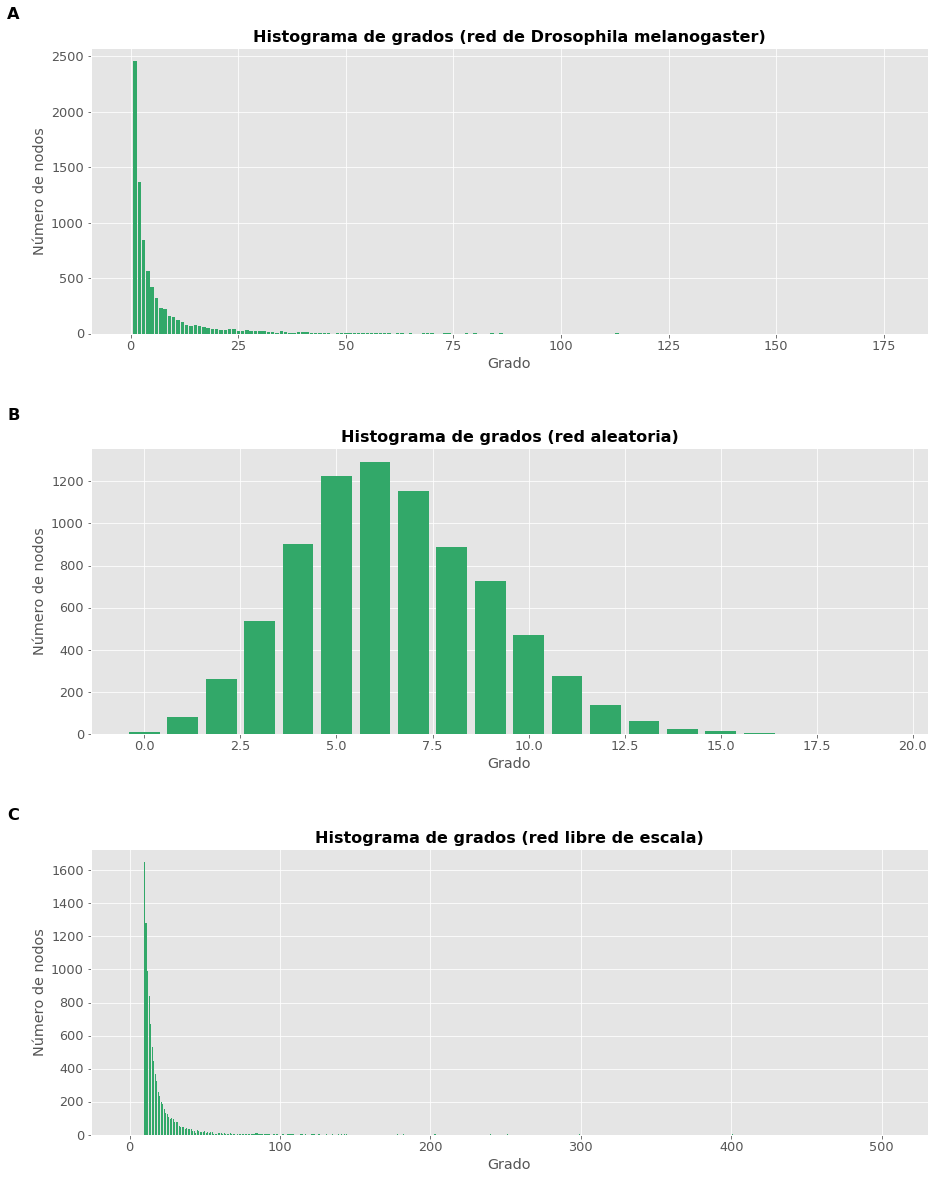

In [16]:
# Cálculo de la distribución de grados de los grafos
L_AL = nx.degree_histogram(G_AL)
L_DM = nx.degree_histogram(G_DM)
with open("./datos/G_SF_metrics.pkl", "rb") as file:
    G_SF_metrics = pickle.load(file)

# Settings representación
textSize = 16
list_titles = ["Histograma de grados (red de Drosophila melanogaster)", "Histograma de grados (red aleatoria)",
               "Histograma de grados (red libre de escala)"]
list_data = [L_DM, L_AL, G_SF_metrics[3]]

# Representación 
fig, axs = plt.subplots(3, 1, figsize = (15, 20))

for nax, ax in enumerate(axs.flat):
    ax.bar(range(len(list_data[nax])), list_data[nax], width = 0.80, color = "#32a869")
    ax.set_title(list_titles[nax], fontweight = "bold", fontsize =  textSize)
    ax.text(-0.1, 1.1, string.ascii_uppercase[nax], transform = ax.transAxes,
            size = textSize + 0.2, weight = 'bold')
    ax.set_ylabel("Número de nodos", fontsize = textSize * 0.9)
    ax.set_xlabel("Grado", fontsize = textSize * 0.9)
    ax.tick_params(labelsize = textSize * 0.8)
plt.subplots_adjust(hspace = 0.4)
plt.savefig("Histograma_grados", format = "png")

* f. ¿Qué conclusión sacas de lo anterior? Dibuja ahora la distribución del grado de los nodos de la red de interacción de proteínas usando escala logarítmica en ambos ejes, añade para ello estas dos líneas de código para cambiar el tipo de escala en cada eje: ``plt.xscale("log", nonposx='clip')``, ``plt.yscale("log", nonposy='clip')``. ¿Qué tipo de gráfica obtienes? ¿Podrías calcular aproximadamente la pendiente de los datos?

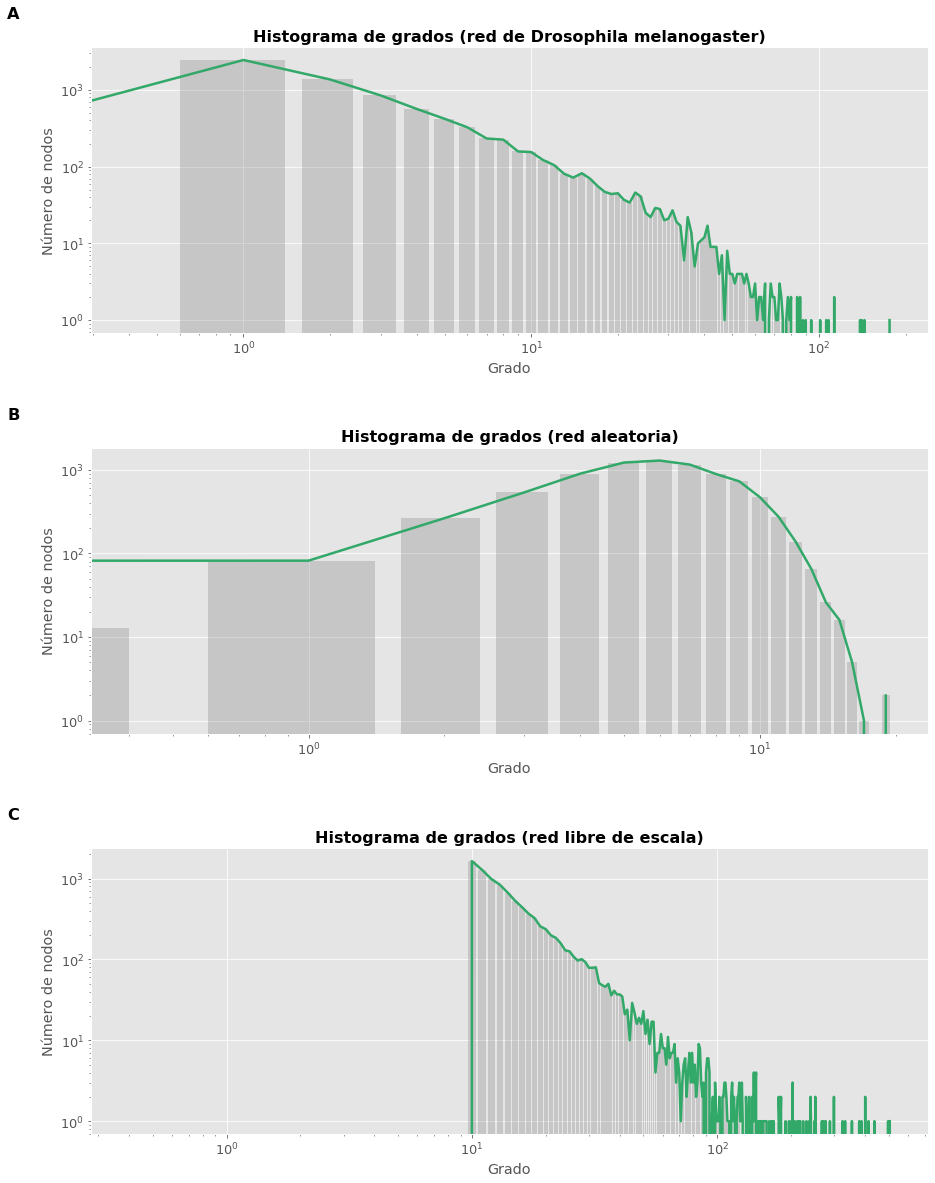

In [17]:
# Representación 
fig, axs = plt.subplots(3, 1, figsize = (15, 20))

for nax, ax in enumerate(axs.flat):
    ax.plot(range(len(list_data[nax])), list_data[nax], color = "#32a869", linewidth = 2.5)
    ax.bar(range(len(list_data[nax])), list_data[nax], alpha = 0.3, color = "grey")
    ax.set_title(list_titles[nax], fontweight = "bold", fontsize =  textSize)
    ax.text(-0.1, 1.1, string.ascii_uppercase[nax], transform = ax.transAxes,
            size = textSize + 0.2, weight = 'bold')
    ax.set_ylabel("Número de nodos", fontsize = textSize * 0.9)
    ax.set_xlabel("Grado", fontsize = textSize * 0.9)
    ax.tick_params(labelsize = textSize * 0.8)
    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')
plt.subplots_adjust(hspace = 0.4)
plt.savefig("Histograma_grados_log", format = "png")

Los resultados obtenidos en esta representación permiten indicar que la red estudiada se trata de una red libre de escala, ya que éstas se caracterizan porque la distribución de grado de sus nodos en escala logarítmica-logarítmica se ajusta a una recta de pendiente negativa que al final tiene un corte o cutoff. Este comportamiento de la distribución de grado se diferencia de lo que ocurre en un grafo aleatorio (sigue una Poisson) o
en uno regular (sigue una Delta).

* g. ¿Cuál es el valor promedio de los coeficientes C (índice de clusterización) y L (camino característico) de cada uno de los grafos?

In [18]:
if os.path.isfile("datos/Gs_metrics_DM.pkl"):
    with open("datos/Gs_metrics_DM.pkl", "rb") as file:
        Gs_metrics = pickle.load(file)
        
else:
    C_DM = nx.average_clustering(G_DM)
    if nx.is_connected(G_DM):
        L_DM = nx.average_shortest_path_length(G_DM)
    else:
        L_DM = nx.average_shortest_path_length(max_connected(G_DM))
    C_AL = nx.average_clustering(G_AL)
    if nx.is_connected(G_AL):
        L_AL = nx.average_shortest_path_length(G_AL)
    else:
        L_AL = nx.average_shortest_path_length(max_connected(G_AL))
    
    Gs_metrics = [C_DM, L_DM, C_AL, L_AL]
    
    with open("datos/Gs_metrics_DM.pkl", "wb") as file:
        pickle.dump(Gs_metrics, file, -1)

In [19]:
print("El índice de clusterización (C) promedio de G_DM es {0}.".format(Gs_metrics[0]))
if nx.is_connected(G_DM):
    print("El camino característico (L) promedio de G_DM es {0}.".format(Gs_metrics[1]))
else:
    print("Dado que el grafo G_DM no es conexo, su camino característico (L) promedio se puede denotar como el",
          "número de nodos - 1 o se puede calcular el L promedio de la componente conexa de mayor tamaño de dicho",
          "grafo, cuyos respectivos valores son: {0}; {1}.".format(int(n - 1), round(Gs_metrics[1], 4)))
print()
print("El índice de clusterización (C) promedio de G_AL es {0}.".format(Gs_metrics[2]))
if nx.is_connected(G_AL):
    print("El camino característico (L) promedio de G_AL es {0}.".format(Gs_metrics[3]))
else:
    print("Dado que el grafo G_AL no es conexo, su camino característico (L) promedio se puede denotar como el",
          "número de nodos - 1 o se puede calcular el L promedio de la componente conexa de mayor tamaño de dicho",
          "grafo, cuyos respectivos valores son: {0}; {1}.".format(int(n - 1), round(Gs_metrics[3], 4)))

El índice de clusterización (C) promedio de G_DM es 0.021679413109029128.
Dado que el grafo G_DM no es conexo, su camino característico (L) promedio se puede denotar como el número de nodos - 1 o se puede calcular el L promedio de la componente conexa de mayor tamaño de dicho grafo, cuyos respectivos valores son: 8079; 4.371.

El índice de clusterización (C) promedio de G_AL es 0.0006154351698906148.
Dado que el grafo G_AL no es conexo, su camino característico (L) promedio se puede denotar como el número de nodos - 1 o se puede calcular el L promedio de la componente conexa de mayor tamaño de dicho grafo, cuyos respectivos valores son: 8079; 5.0247.


Las propiedades de las redes libres de escala son: camino característico corto, incluso más que en el grafo aleatorio equivalente; índice de clusterización pequeño y decreciente (a mayor número de nodos), pero mayor que el del grafo aleatorio equivalente. En este caso, el índice de clusterización de la red libre de escala es varios órdenes de magnitud mayor que el de la red aleatoria equivalente, de forma que hay un sesgo en la misma; mientras que el camino característico de la red libre de escala es más pequeño que el de la red aleatoria equivalente. Así, ambas propiedades se cumplen.

## Detección de comunidades

Dado que se trata de una red libre de escala (no llega a serlo por el tamaño, pero tiene todas las propiedades, probablemente se pueda considerar libre de escala), podemos partirla en comunidades y ver qué proteínas están relacionadas entre sí. Dado que son symbols, se puede mirar con qué tienen que ver, no es más que coger los nodos y utilizar código que ya está hecho. 

In [20]:
# algoritmo de Louvain: heurístico, el óptimo es NP-completo
# 40 iteraciones, mejor partición (revisar)
modu = 0
for i in range(40):
    partition = community_louvain.best_partition(G_DM)
    x = community_louvain.modularity(partition, G_DM)

    if x > modu:
        modu = x
        best_partition = partition

In [21]:
num_com = max(best_partition.items(), key = lambda x: x[1])
range_com = range(num_com[1])

length = []
for i in range_com:
    x = list(filter(lambda y: y[1] == i, best_partition.items()))
    length.append(len(x))

# index con longitudes
index_len = zip(list(range_com), length)

# comunidades ordenadas por tamaño
sort_len = sorted(index_len, key = lambda x: x[1], reverse = True)

# proteínas de la comunidad de mayor tamaño
com_max_size = list(filter(lambda x: x[1] == sort_len[0][0], best_partition.items()))

# pos_max = length.index(max(length))
# max_com = np.array(list(best_partition.keys()))[np.array(list(best_partition.values())) == pos_max]

In [22]:
print(*com_max_size, sep = ", ")

('PNN', 5), ('EBI-2111454', 5), ('CAP', 5), ('CG5792', 5), ('CG15059', 5), ('CG13733', 5), ('CRN', 5), ('CG32086', 5), ('CG14145', 5), ('EBI-208011', 5), ('CG1135', 5), ('CG11881', 5), ('CG6972', 5), ('CG3213', 5), ('CG9797', 5), ('EBI-149916', 5), ('DX', 5), ('TRAF3', 5), ('RPL35A', 5), ('EBI-166329', 5), ('CG8065', 5), ('CG9331', 5), ('CG4617', 5), ('SMB', 5), ('CG11905', 5), ('EBI-218484', 5), ('CG3294', 5), ('CG10918', 5), ('BETATUB56D', 5), ('CG2926', 5), ('CG3654', 5), ('BIP2', 5), ('CG15646', 5), ('EBI-124402', 5), ('CG1647', 5), ('EBI-88363', 5), ('EBI-117463', 5), ('BSG25D', 5), ('EBI-134407', 5), ('C15', 5), ('EBI-201372', 5), ('CG32809', 5), ('CG5050', 5), ('CRC', 5), ('CG11164', 5), ('P115', 5), ('EBI-195768', 5), ('CG14868', 5), ('CG4925', 5), ('CG9392', 5), ('VHAAC39', 5), ('STEP', 5), ('PRM', 5), ('CG4095', 5), ('CG7357', 5), ('EBI-206607', 5), ('CG10750', 5), ('SO', 5), ('CG13084', 5), ('EBI-85713', 5), ('CG8159', 5), ('EBI-190547', 5), ('EBI-206443', 5), ('EBI-92995', 

In [23]:
print(*sort_len, sep = ", ")

print("Comunidades con más de 100 nodos: ", sum(np.array(sort_len)[:,1] > 100))

(5, 1217), (0, 917), (19, 813), (1, 717), (2, 663), (20, 405), (10, 347), (6, 312), (9, 301), (4, 270), (21, 186), (8, 179), (3, 175), (12, 169), (27, 167), (28, 150), (26, 146), (29, 129), (22, 124), (18, 117), (31, 116), (11, 95), (25, 78), (15, 74), (34, 42), (23, 5), (36, 5), (53, 5), (52, 4), (55, 4), (66, 4), (7, 3), (13, 3), (24, 3), (30, 3), (37, 3), (40, 3), (41, 3), (43, 3), (47, 3), (50, 3), (58, 3), (63, 3), (64, 3), (14, 2), (16, 2), (17, 2), (32, 2), (33, 2), (35, 2), (39, 2), (42, 2), (44, 2), (45, 2), (48, 2), (49, 2), (51, 2), (56, 2), (61, 2), (62, 2), (65, 2), (67, 2), (68, 2), (69, 2), (70, 2), (71, 2), (73, 2), (74, 2), (75, 2), (76, 2), (79, 2), (80, 2), (81, 2), (82, 2), (83, 2), (84, 2), (85, 2), (86, 2), (87, 2), (88, 2), (89, 2), (92, 2), (93, 2), (94, 2), (95, 2), (96, 2), (97, 2), (98, 2), (99, 2), (100, 2), (38, 1), (46, 1), (54, 1), (57, 1), (59, 1), (60, 1), (72, 1), (77, 1), (78, 1), (90, 1), (91, 1)
Comunidades con más de 100 nodos:  21


# Cliqué

In [24]:
# Devuelve todos los cliques de un grafo no dirigido.
print(len(list(nx.enumerate_all_cliques(G_DM))))
print(len(list(nx.enumerate_all_cliques(G_AL))))

# Da el número de cliqués maximales del grafo.
print(nx.graph_number_of_cliques(G_DM))
print(nx.graph_number_of_cliques(G_AL))

print(nx.graph_clique_number(G_DM))
print(nx.graph_clique_number(G_AL))

# if os.path.isfile("datos/Omega_DM.pkl"):
#     with open("datos/Omega_DM.pkl", "rb") as file:
#         Omegas = pickle.load(file)
# else:
#     Omega_DM = nx.omega(G_DM)
#     Omega_AL = nx.omega(G_AL)
#     Omegas = [Omega_DM, Omega_AL]
#     with open("datos/Omega_DM.pkl", "wb") as file:
#         pickle.dump(Omegas, file, -1)

38048
34323
23544
26118
8
3


In [25]:
# print(Omegas[0])
# print(Omegas[1])

## Comparaciones para más de un grafo aleatorio

In [26]:
# Definición de la función L_C_Random
def L_C_Random(graphs_number, n, m):
    C = []
    L = []
    for graph in range(graphs_number):
        G = nx.gnm_random_graph(n, m)
        C.append(nx.average_clustering(G))
        if nx.is_connected(G):
            L.append(nx.average_shortest_path_length(G))
        else:
            G_max = max_connected(G)
            L.append(nx.average_shortest_path_length(G_max))
            
    return L, C

In [20]:
def kcore_Random(graphs_number, n, m, k_max):
    cont = 0
    for graph in range(graphs_number):
        G = nx.gnm_random_graph(n, m)
        Kcore_AL = nx.core_number(G_AL_no_loops)
        if max(Kcore_AL.values()) >= k_max:
            cont += 1            
    return cont

In [21]:
print(kcore_Random(100, n, m, 11))

0


In [27]:
# if os.path.isfile("datos/random_comparaciones_DM.pkl"):
#     with open("datos/random_comparaciones_DM.pkl", "rb") as file:
#         random_comparaciones = pickle.load(file)
# else:
#     random_comparaciones = L_C_Random(10, n, m)
#     with open("datos/random_comparaciones_DM.pkl", "wb") as file:
#         pickle.dump(random_comparaciones, file, -1)

In [28]:
# cont = 0
# for L in random_comparaciones[0]:
#     if Gs_metrics[1] <= L:
#         cont += 1
# print(cont/10)
# cont = 0
# for C in random_comparaciones[1]:
#     if Gs_metrics[0] <= C:
#         cont += 1
# print(cont/10)